# 1) Data Exploration

In [3]:
import urllib
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

## 1.1) Load Data

- We will use 2 to 3 images of both S1 and S2 satellites to build the model. Right now, the dimensionality of the input and output need to be decided first.
- Data from 1 chip_id "000aa810" is in the 'data' folder from the project.
- It's also important to start working with the metadata .csv files from the project as they will help to track data for training and 
- Data is downloaded from a AWS bucket, best way to get it is by CLI. We need to install AWS CLI in this package

In [7]:
features = pd.read_csv(f'../data/features_metadata.csv')
train_agbm = pd.read_csv(f'../data/train_agbm_metadata.csv')
features.head(5)

,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm,file_downloaded,file_in_GCS
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,1049524,3953454613,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,True,True
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,1049524,3531005382,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,True,True
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,1049524,1401197002,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,True,True
3,0003d2eb_S1_03.tif,0003d2eb,S1,train,December,1049524,3253084255,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,True,True
4,0003d2eb_S1_04.tif,0003d2eb,S1,train,January,1049524,2467836265,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,True,True


In [8]:
train_agbm.head(5)

,filename,chip_id,size,cksum,s3path_us,s3path_eu,s3path_as
0,0003d2eb_agbm.tif,0003d2eb,262482,2036246549,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
1,000aa810_agbm.tif,000aa810,262482,2858468457,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
2,000d7e33_agbm.tif,000d7e33,262482,277850822,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
3,00184691_agbm.tif,00184691,262482,3502312579,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...
4,001b0634_agbm.tif,001b0634,262482,2397957274,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...


In [10]:
# Read tif file and get a numpy array 
def image_to_np(path, filename):
  file = os.path.abspath(f'{path}{filename}')
  return tifffile.imread(file)

In [12]:
XS1 = image_to_np('../data/train data/' , '000aa810_S1_00.tif')
XS2 = image_to_np('../data/train data/' , '000aa810_S2_06.tif')
y = image_to_np('../data/ground truth/' , '000aa810_agbm.tif')

### 1.1.1) Compress Data (?)

Do we need to do this - change dtypes?

## 1.2) Clean Data

Do we need to do this?
How do we deal with the months data?

## 1.3) Visualize Data

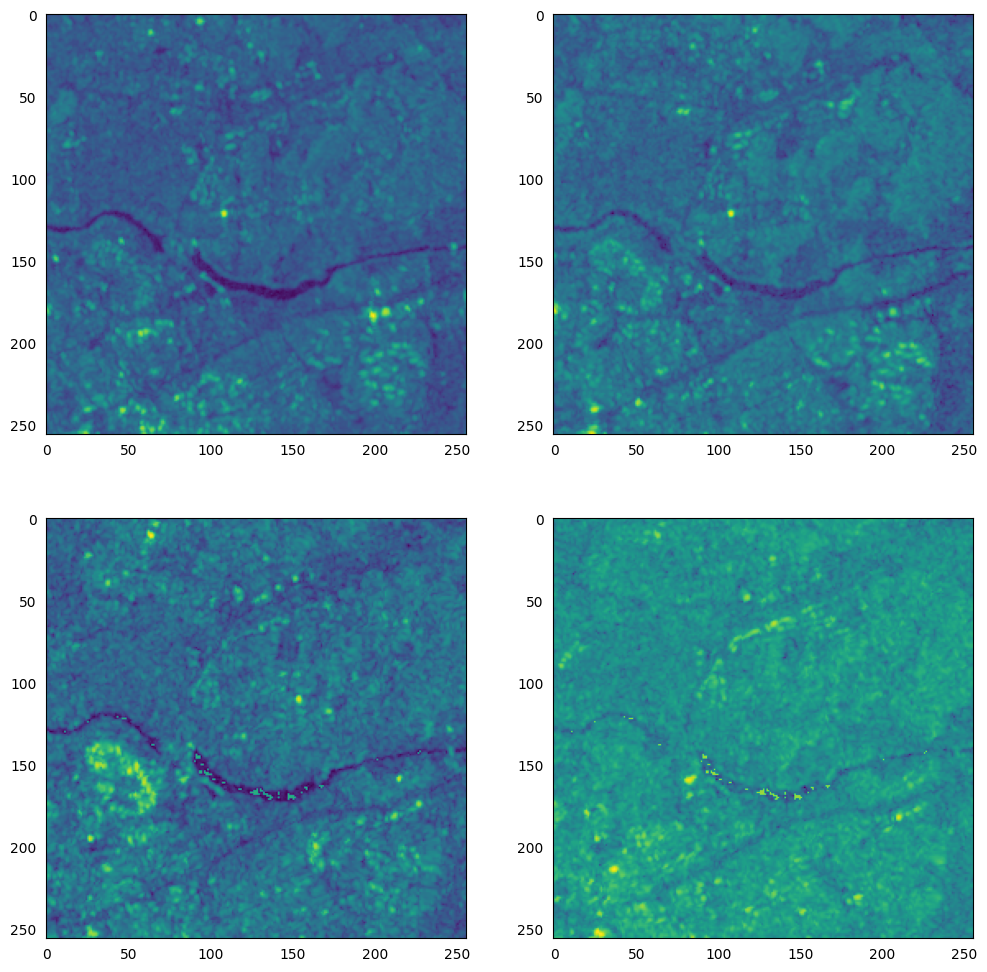

In [18]:
# Function to visualize S1 bands
def S1_view (img):
    _, ax = plt.subplots(2,2, figsize=(12,12))
    ax[0,0].imshow(img[:,:,0]);
    ax[0,0].tick_params(bottom=False, left=False)
    ax[0,1].imshow(img[:,:,1]);
    ax[0,1].tick_params(bottom=False, left=False)
    ax[1,0].imshow(img[:,:,2]);
    ax[1,0].tick_params(bottom=False, left=False)
    ax[1,1].imshow(img[:,:,3]);
    ax[1,1].tick_params(bottom=False, left=False)
    img.shape
    
S1_view(XS1)

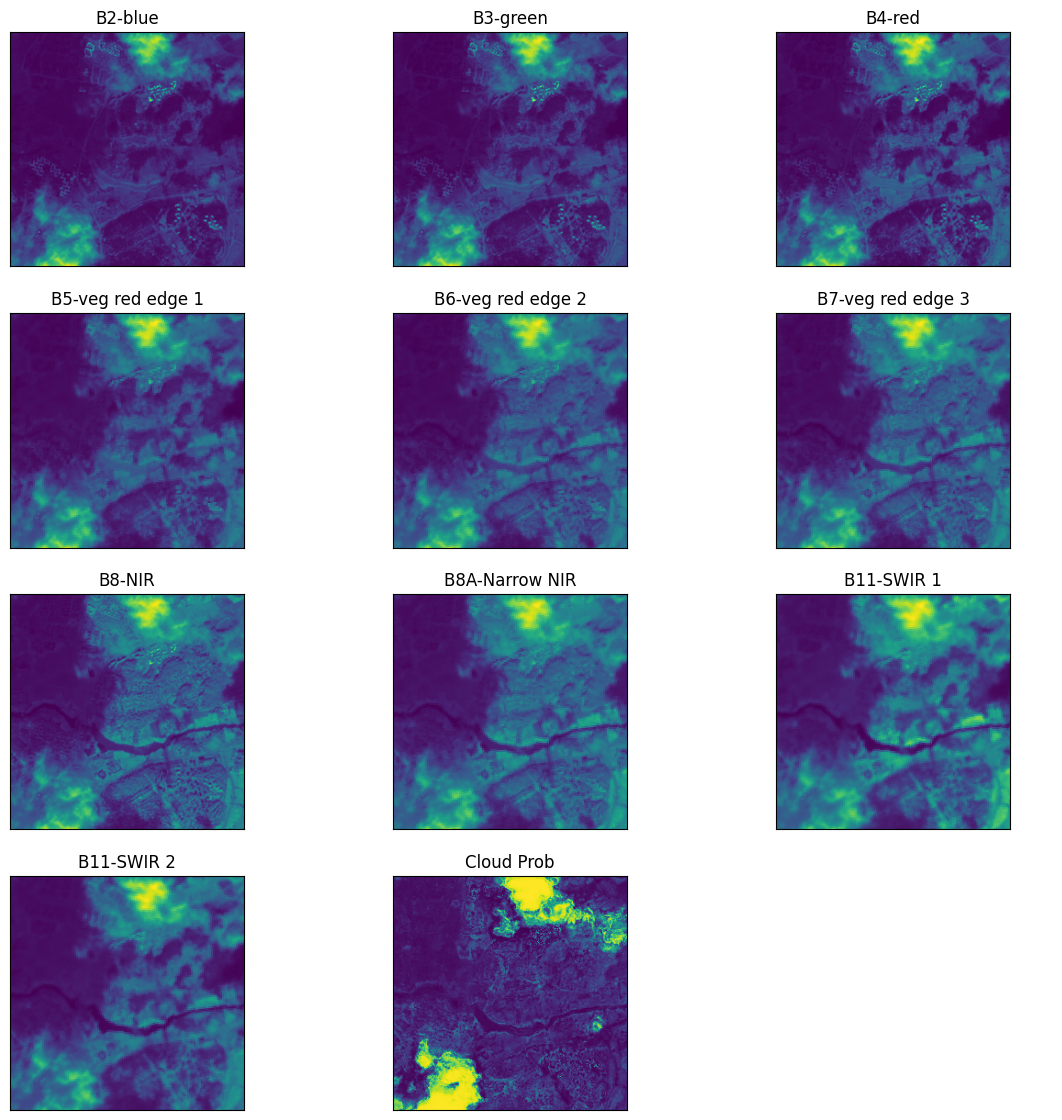

In [19]:
# Function to visualize the 11 bands from S2 images
def S2_image(img):
    axes = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2], 
            [3,0], [3,1]]
    images = list(range(11))
    titles = ['B2-blue','B3-green','B4-red', 'B5-veg red edge 1', 
              'B6-veg red edge 2', 'B7-veg red edge 3', 'B8-NIR', 
              'B8A-Narrow NIR', 'B11-SWIR 1', 'B11-SWIR 2', 'Cloud Prob']

    fig, ax = plt.subplots(4,3, figsize=(14,14))

    for ij, img_num, title in zip(axes, images, titles):
            ax[ij[0],ij[1]].imshow(img [:, :, img_num]);
            ax[ij[0],ij[1]].set_title(title)
            ax[ij[0],ij[1]].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        
    plt.axis('off')
    ax[3,2].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    
S2_image(XS2)

([], [])

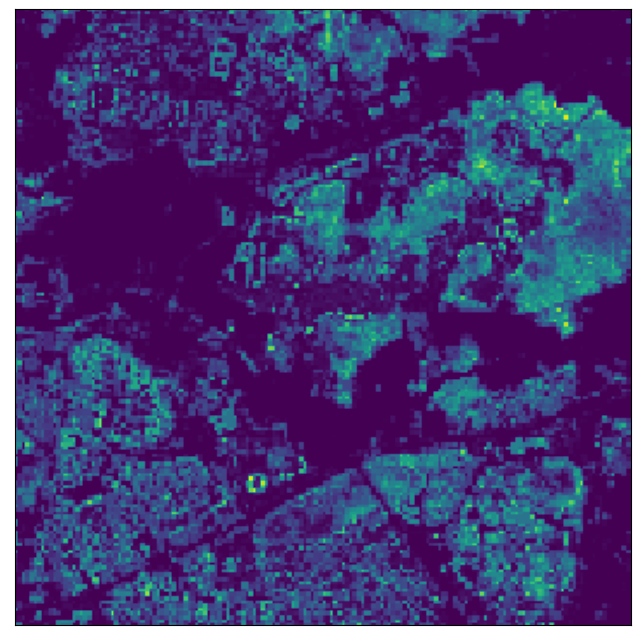

In [20]:
# Visualizing LiDAR image
plt.figure(figsize = (8,8))
plt.imshow(y)
plt.xticks([])
plt.yticks([])

### 1.4) Baseline Score  - Preliminary Intuitions

We can use the scoring from other competitors in this challenge: 28
That's the score we need to beat.

☝️ Get formula to calculate the model performance (average RSME)

# 2) Preprocessing ****

We are given a dataset with only 5 features (passengers + lon/lat), and potentially dozens of millions of rows.

👉 It makes perfect sense to create a lot of "engineered" features such as "hour of the day"  
- Hundreds of them would cause no problem because the huge number of rows will allow our model to learn all weights associated with these multiple features
- A dense, Deep Learning network will be well-suited for such a case

❗️ The proposed preprocessor below outputs a **fixed number of features** (65) that is **independent of the training set**. You will see that it will come in handy when scaling it up to hundreds of millions of rows

In [ ]:
X = df.drop("fare_amount", axis=1)
y = df[["fare_amount"]]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 2.1) Passenger Preprocessors

Let's analyze passenger numbers

In [ ]:
sns.histplot(df.passenger_count)

In [ ]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p-p_min)/(p_max-p_min))

In [ ]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
    ],
)
preprocessor

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train))

## 2.2) Time Preprocessor

First, let's extract category attributes from the `pickup_datetime`

In [ ]:
import math

def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    pickup_dt = pd.to_datetime(
        X["pickup_datetime"],
        format="%Y-%m-%d %H:%M:%S UTC",
        utc=True
    )

    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt

    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    return np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "year"]).head()

Then, one-hot-encode ["day of week", "month"] by forcing all 24*7 combinations of categories to be always present in X_processed (remember we want a fixed size for X_processed at the end)

In [ ]:
time_categories = {
        0: np.arange(0, 7, 1),  # days of the week from 0 to 6
        1: np.arange(1, 13, 1)  # months of the year from 1 to 12
    }

OneHotEncoder(categories=time_categories, sparse=False)\
    .fit_transform(X_time_processed[:,[2,3]]) # column index [2,3] for ['dow', 'month'] !

And combine this with a re-scaling of the year

In [ ]:
print(df.pickup_datetime.min())
print(df.pickup_datetime.max())

In [ ]:
year_min = 2009
year_max = 2019 # Our model may extend in the future. No big deal if the scaled data extend slightly beyond 1.0

In [ ]:
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"
        ), [2, 3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - year_min) / (year_max - year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
    ],
)

preprocessor

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');

☝️ 23 features approximately centered and scaled

## 2.3) Distance Pipeline

Let's add both the haversine and Manhattan distances as features

In [ ]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [ ]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and Manhattan distances between two points (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in Km
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius

    return dict(
        haversine = haversine_km,
        manhattan = manhattan_km
    )

In [ ]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:
    assert isinstance(X, pd.DataFrame)
    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances

In [ ]:
dist_min = 0
dist_max = 100

In [ ]:
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
    )
distance_pipe

In [ ]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor

In [ ]:
X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');

☝️ 25 features, approximately scaled

## 2.4) GeoHasher

Finally, let's add information about **districts**! 

Some might be more expensive than others to go to/depart from (e.g. JFK airport!)

To _bucketize_ geospatial information, we'll use `pygeohash`

In [ ]:
import pygeohash as gh

💡 pygeohash converts (lat,lon) into geospacial "squared buckets" of chosen precisions. The more precision you ask, the more "buckets" possibility there is!

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/geohashes.png">

In [ ]:
x0 = X_train.iloc[0,:]
(x0.pickup_latitude, x0.pickup_longitude)

In [ ]:
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=3))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=4))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=5))

👇 Let's apply it to ALL of our data set (note that this preprocessing may take a very long time!)

In [ ]:
def compute_geohash(X:pd.DataFrame, precision:int = 5) -> np.ndarray:
    """
    Add a geohash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]

In [ ]:
compute_geohash(X_train)

☝️ Notice that this time, we have no choice but to apply `pygeohash` row by row with `df.apply(axis=1)`, and it takes a while to compute.

This is the danger of relying on an external Python library that is not always vectorized. 

👇 What are the most common districts?

In [ ]:
all_geohashes = pd.concat([
    X_train.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1),
    X_train.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1),
])

In [ ]:
print(len(all_geohashes.value_counts()))
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(all_geohashes.value_counts()[:20])/(2*len(X_train))*100)
plt.title("percentage of taxi rides from/to these districts");

☝️ Only the first 20 districts matter. We can one-hot encode them.

In [ ]:
most_important_geohash_districts = np.array(all_geohashes.value_counts()[:20].index)
most_important_geohash_districts

In [ ]:
# Let's hard-code below the 20 most frequent district GeoHashes of precision 5,
# covering about 99% of all dropoff/pickup locations.
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

Let's one-hot encode each GeoHash in one of the top-20 different buckets listed above


In [ ]:
geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse=False
    )
)
geohash_pipe

## 2.5) Full Preprocessing Pipeline

Let's recap our final preprocessor

### a) Encoders

In [ ]:
import math
import numpy as np
import pandas as pd
import pygeohash as gh

In [ ]:
def transform_time_features(X: pd.DataFrame)->np.ndarray:
    assert isinstance(X, pd.DataFrame)
    
    pickup_dt = pd.to_datetime(
        X["pickup_datetime"],
        format="%Y-%m-%d %H:%M:%S UTC",
        utc=True
    )

    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt

    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    result = np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

    return result

In [ ]:
def transform_lonlat_features(X: pd.DataFrame) -> pd.DataFrame:

    assert isinstance(X, pd.DataFrame)
    lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

    def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
        """
        Calculate the haversine and Manhattan distances between two points on the earth (specified in decimal degrees).
        Vectorized version for pandas df
        Computes distance in Km
        """
        earth_radius = 6371

        lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
        lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

        dlon_rad = lon_2_rad - lon_1_rad
        dlat_rad = lat_2_rad - lat_1_rad

        manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
        manhattan_km = manhattan_rad * earth_radius

        a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
        haversine_rad = 2 * np.arcsin(np.sqrt(a))
        haversine_km = haversine_rad * earth_radius

        return dict(
            haversine=haversine_km,
            manhattan=manhattan_km)

    result = pd.DataFrame(distances_vectorized(X, *lonlat_features))

    return result

In [ ]:
def compute_geohash(X: pd.DataFrame, precision: int = 5) -> np.ndarray:
    """
    Add a GeoHash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up, and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]

### b) Pipeline

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [ ]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p - p_min) / (p_max - p_min))

# DISTANCE PIPE
dist_min = 0
dist_max = 100

distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
)

# TIME PIPE
year_min = 2009
year_max = 2019

time_categories = {
    0: np.arange(0, 7, 1),  # days of the week
    1: np.arange(1, 13, 1)  # months of the year
}

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories=time_categories,
            sparse=False,
            handle_unknown="ignore"
        ), [2,3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - year_min) / (year_max - year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

# GEOHASH PIPE
lonlat_features = [
    "pickup_latitude", "pickup_longitude", "dropoff_latitude",
    "dropoff_longitude"
]

# Below are the 20 most frequent district geohashes of precision 5,
# covering about 99% of all dropoff/pickup locations,
# according to prior analysis in a separate notebook
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse=False
    )
)

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
        ("geohash", geohash_pipe, lonlat_features),
    ],
    n_jobs=-1,
)

In [ ]:
final_preprocessor

In [ ]:
X_train_processed = final_preprocessor.fit_transform(X_train)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');

To conclude, we compress our data to float32

In [ ]:
X_train_processed.dtype

In [ ]:
print(X_train_processed.nbytes / 1024**2, "MB")

In [ ]:
# Compress the data a bit
X_train_processed = X_train_processed.astype(np.float32)
print(X_train_processed.nbytes / 1024**2, "MB")

In [ ]:
pd.DataFrame(X_train_processed)

☝️ The preprocessor outputs a **fixed** number of features (65) that is independent of the training set. 

☝️ The preprocessor is also  **state-less** (i.e it has no `.fit()` method, only a `.transform()`). It can be seen as a *pure function* $f:X \rightarrow X_{processed}$ without an internal state, as opposed to standard scaling for instance, which has to store "X_train standard deviations" as internal states.

These two features will make work much easier for the ML Engineering team to scale preprocessing to hundreds of GBs. 

# 3) Model

❓ To begin with, please install `tensorflow` >=2.8 on your `taxifare-env`

For instance, you can add one of the following lines to `requirements.txt`

```
tensorflow-macos==2.10.0 ; sys_platform == "darwin"
tensorflow==2.10.0 ; sys_platform == "linux"
```

And then `pip install -e .` to install it on `taxifare-env`



## 3.1) Architecture

In [ ]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def initialize_model(X: np.ndarray) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l2=0.01)

    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=X.shape[1:]))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg, input_shape=X.shape[1:]))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(50, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.99)) # use momentum=0 for to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model

In [ ]:
model = initialize_model(X_train_processed)
model.summary()

In [ ]:
learning_rate = 0.001
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

In [ ]:
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

history = model.fit(
    X_train_processed,
    y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

## 3.2) Performance evaluation

In [ ]:
X_test_processed = final_preprocessor.transform(X_test)

In [ ]:
y_pred = model.predict(X_test_processed)

In [ ]:
model.evaluate(X_test_processed, y_test)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)

plt.legend()
plt.xlim((0,60))

In [ ]:
residuals = y_pred - y_test

In [ ]:
residuals.describe()

In [ ]:
residuals = y_pred - y_test
sns.histplot(residuals)
plt.xlim(xmin=-20, xmax=20)

In [ ]:
residuals.sort_values(by='fare_amount')

In [ ]:
# Residual vs. actual scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=residuals, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('residuals')

In [ ]:
# Residual vs. predicted scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_pred,y=residuals, alpha=0.1)
plt.xlabel('predicted')
plt.ylabel('residuals')

☝️ Our model has an MAE of about 2$ per course, compared with a mean course price of 11$.  

A simple linear regression would give us about 2.5$ of MAE, but the devil lies in the details!

In particular, we're not that good at predicting very long/expensive courses

# 🧪 Test Your Understanding

❓ Try to answer these questions with your buddy
1. Are you satisfied with the model's performance?
2. What is a stateless pipeline (as opposed to a stateful one)?
3. How does an OHEncoder work with fixed column categories?
4. How is the data normalization done in the Neural Net?

<details>
  <summary markdown='span'>💡 Answers</summary>

1. We have a 25% improvement over the linear regression baseline, and it seems that our model has been doing its best, given the features it has been provided with. Besides, a 2$ forecast error on taxi courses whose prices also depend on traffic seems close to the irreducible error rate.
2. A stateless pipeline has no real `.fit()` method, only a `.transform()`. 
3. To become stateless, we've hard-coded the `categories` to one-hot encode `OneHotEncoder(categories=categories,...)` and hard-coded the statistical features of each column in our scalers:  `FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))`
4. In the TensorFlow model, notice the `layers.BatchNormalization()` we've added between each dense layer, which normalizes data batch-per-batch! It's a cool feature to help fix vanish gradients during the back-propagation!
</details>

❓ Predict the price for this new course `X_new` below and store the result `y_new` as a `np.ndarray`

In [ ]:
X_new = pd.DataFrame(dict(
    key=["2013-07-06 17:18:00"],  # useless but the pipeline requires it
    pickup_datetime=["2013-07-06 17:18:00 UTC"],
    pickup_longitude=[-73.950655],
    pickup_latitude=[40.783282],
    dropoff_longitude=[-73.984365],
    dropoff_latitude=[40.769802],
    passenger_count=[1]
))

X_new

In [ ]:
pass  # YOUR CODE HERE

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'notebook',
    subdir='train_at_scale',
    y_new=y_new
)

result.write()
print(result.check())